<a href="https://colab.research.google.com/github/ymuto0302/base2_2020/blob/master/GIS3_market_area_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 商圏に居住する人口を求める方法
単純な例を用いて，商圏に居住する人口を数える方法を説明する

## (準備) geopandas および rtree のインストール
本ノートブック上で sjoin() を利用するため，rtree が必要となる。

また，geopandas について，Google Colab が標準で提供する geopandas はバージョンの整合が取れていないようだから，github から最新のソースを持ってくる。

（参考にしたサイト）https://colab.research.google.com/drive/1Kt3vPVIQJUq4QeJ-rE08URpIJEr1g2H3#scrollTo=DT-2i68kvoiN

In [1]:
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-_02rhzcs
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-_02rhzcs
  Created wheel for geopandas: filename=geopandas-0.8.0+56.g9fdeb14-py2.py3-none-any.whl size=969954 sha256=994bac21b097a1e6075a4d47e7fdb66084e81b580fb47f87cf0be457350f13ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-1w40gvxd/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas
  Found existing installation: geopandas 0.7.0
    Uninstalling geopandas-0.7.0:
      Successfully uninstalled geopandas-0.7.0


In [2]:
!apt install python3-rtree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  python3-pkg-resources python3-rtree
0 upgraded, 2 newly installed, 0 to remove and 18 not upgraded.
Need to get 116 kB of archives.
After this operation, 640 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-rtree all 0.8.3+ds-1 [16.9 kB]
Fetched 116 kB in 1s (227 kB/s)
Selecting previously unselected package python3-pkg-resources.
(Reading database ... 144681 files and directories currently installed.)
Preparing to unpack .../python3-pkg-resources_39.0.1-2_all.deb ...
Unpacking python3-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python3-rtree.

## 居住地域およびその人口の定義
ここではポリゴンを用いて，２つの領域および各領域に住む人口を設定する。

In [3]:
import geopandas as gpd
from shapely.geometry import Polygon

# 人が住む領域の設定
cordinates = [[(10, 10), (20, 10), (20, 20), (10, 20)],
              [(30, 30), (40, 30), (40, 40), (30, 40)]]

# 各地区の人口
pops = [30, 50]

# [[人口A, Polygon-A], [人口B, Polygon-B], ...] の形のリストを作る
data = list()
for cordinate, pop in zip(cordinates, pops):
    data.append([pop, Polygon(cordinate)])

# GeoDataFrame の生成
pop = gpd.GeoDataFrame(data, columns=['pop', 'geometry'], crs='EPSG:4612')

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


居住地域を可視化する。ここで人口は反映されない（plot() が見ているのは geometry のみ）。

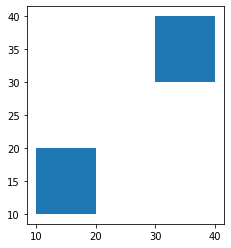

In [4]:
# 可視化 (確認用)
pop.plot()

In [5]:
# GeoDataFrame の中身を覗き見する
pop

,pop,geometry
0,30,"POLYGON ((10.00000 10.00000, 20.00000 10.00000..."
1,50,"POLYGON ((30.00000 30.00000, 40.00000 30.00000..."


## 店舗および商圏の定義
ここでは２つの店舗を考える。それぞれは Point (点) として表現される。

In [6]:
# 店舗の定義
from shapely.geometry import Point

shopping = gpd.GeoDataFrame([['shopA', Point(15, 15)],
                             ['shopB', Point(30, 30)]],
                            columns=['name', 'geometry'],
                            crs='EPSG:4612')

In [7]:
# 変数の中身を覗き見る
shopping

,name,geometry
0,shopA,POINT (15.00000 15.00000)
1,shopB,POINT (30.00000 30.00000)


店舗を中心とした半径 buffer_size の領域を商圏とする。

次のように buffer() メソッドによりポリゴンを生成できる。

In [8]:
# ポイント(Point)のバッファをとると，ポリゴンを作ることができる
buffer_size = 10
shopping_areas = shopping.copy() # 'name 列を引き継ぐため，コピーする'
shopping_areas['geometry'] = shopping.buffer(buffer_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [9]:
# 変数の中身を覗き見ると，確かにポリゴンになっている！
shopping_areas

,name,geometry
0,shopA,"POLYGON ((25.00000 15.00000, 24.95185 14.01983..."
1,shopB,"POLYGON ((40.00000 30.00000, 39.95185 29.01983..."


## 居住地と商圏の可視化
居住地 resident と商圏 shopping_area を可視化し，これらの位置関係を確認する。

居住地を青色，商圏を赤（透明度 0.4）で表現した。

左下では，商圏内に居住地がすっぽり含まれることが分かる。また，右上では，居住地の一部が商圏内に入りきれない状態である。

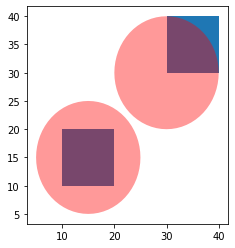

In [10]:
# 試しに可視化してみる
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
pop.plot(ax=ax)
shopping_areas.plot(ax=ax, color='red', alpha=0.4)

## 居住地と商圏を空間的に結合した GeoDataFrame の生成
空間結合 (spatial join) とは，２つのポリゴン＝領域の重なったデータを取り出す操作である。
次のように geopandas.sjoin() により実現でき，その文法は以下のとおりである。

    geopandas.sjoin(刺されるデータフレーム，刺すデータフレーム，op=操作)
    
op に指定できる操作には 'within', 'intersects', 'contatins' を指定できる。

In [11]:
# pop と shopping area の空間的な(spatial)結合
joined = gpd.sjoin(pop, shopping_areas, op='within')

この例では 'within' を指定している。

pop は shopping_areas の内部 (within) か，という意味であり，

商圏 shipping_areas に完全に含まれる領域およびそこに居住する人口が抽出される。

In [12]:
# sjoin された結果を表示
joined

,pop,geometry,index_right,name
0,30,"POLYGON ((10.00000 10.00000, 20.00000 10.00000...",0,shopA


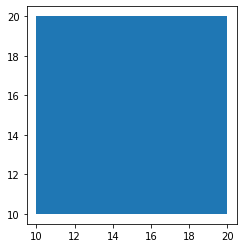

In [13]:
# 一応，可視化
joined.plot()

### (参考) sjoin の op に within, intersects, contains を指定した場合の挙動

   pop                                           geometry  index_right   name
0   30  POLYGON ((10.00000 10.00000, 20.00000 10.00000...            0  shopA


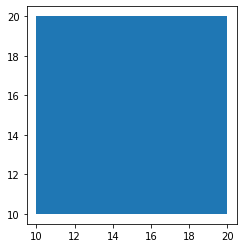

In [14]:
# resident と shopping area の空間的な(spatial)結合
# op = 'within' の場合
joined_2 = gpd.sjoin(pop, shopping_areas, op='within')
print(joined_2)
joined_2.plot()

   pop                                           geometry  index_right   name
0   30  POLYGON ((10.00000 10.00000, 20.00000 10.00000...            0  shopA
1   50  POLYGON ((30.00000 30.00000, 40.00000 30.00000...            1  shopB


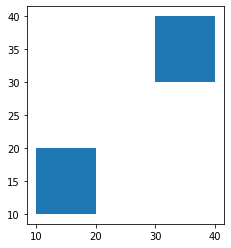

In [15]:
# resident と shopping area の空間的な(spatial)結合
# op = 'intersects' の場合
# intersection (共通部分) ゆえ，少しでも商圏がひっかかれば対象となる
joined_3 = gpd.sjoin(pop, shopping_areas, op='intersects')
print(joined_3)
joined_3.plot()

In [16]:
# resident と shopping area の空間的な(spatial)結合
# op = 'contains' の場合
# pop のエリアが shopping_area を包含するケースがないため，例外となる
joined_4 = gpd.sjoin(pop, shopping_areas, op='contains')
print(joined_4)
joined_4.plot()

Empty GeoDataFrame
Columns: [pop, geometry, index_right, name]
Index: []


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:612: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1cc4371a60> (for post_execute):


ValueError: ignored

ValueError: ignored

# 人口分布の解像度を高めて試してみる
本節では，商圏に含まれる「複数の居住地」に居住する人口の合計を求めることが目的である。

最初に４つの居住地を設定する。コードと可視化した結果を突き合わせれば，意味が分かるだろう。

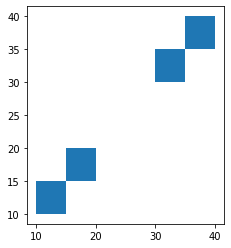

In [17]:
import geopandas as gpd
from shapely.geometry import Polygon
import fiona
from fiona.crs import from_epsg

# polygon を作る場合，境界線を結ぶ順番に座標を並べる
cordinates = [[(10, 10), (15, 10), (15, 15), (10, 15)],
              [(15, 15), (20, 15), (20, 20), (15, 20)],
              [(30, 30), (35, 30), (35, 35), (30, 35)],
              [(35, 35), (40, 35), (40, 40), (35, 40)]
             ]

pops = [30, 50, 100, 70]

# [[人口A, Polygon-A], [人口B, Polygon-B], ...] の形のリストを作る
data = list()
for cordinate, pop in zip(cordinates, pops):
    data.append([pop, Polygon(cordinate)])

# GeoDataFrame の生成
pop = gpd.GeoDataFrame(data, columns=['pop', 'geometry'], crs='EPSG:4612')

# 可視化 (確認用)
pop.plot()

続けて，２つの店舗を定義し，それぞれの商圏を設定する。

In [18]:
# 店舗の定義
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg

shopping = gpd.GeoDataFrame([['shopA', Point(15, 15)],
                             ['shopB', Point(30, 30)]],
                            columns=['name', 'geometry'],
                            crs='EPSG:4612')

In [19]:
# ポイント(Point)のバッファをとると，ポリゴンを作ることができる
buffer_size = 10 # 10[m]
shopping_areas = shopping.copy() # 'name 列を引き継ぐため，コピーする'
shopping_areas['geometry'] = shopping.buffer(buffer_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


居住地と商圏の位置関係を可視化した結果を以下に示す。
- 図の左下が "shopA" の商圏，右上が "shopB" の商圏である。
- "shopA" の商圏には２つの居住地が，"shopB" の商圏には１つの居住地が含まれている。

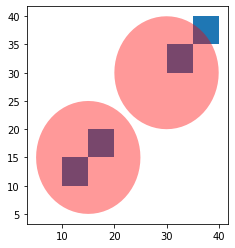

In [20]:
# 試しに可視化してみる
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
pop.plot(ax=ax)
shopping_areas.plot(ax=ax, color='red', alpha=0.4)

空間結合した結果を以下に示す。

"shopA" と２つの居住地が対応づけられたことが分かるだろう。

In [21]:
# resident と shopping area の空間的な(spatial)結合
joined = gpd.sjoin(pop, shopping_areas, op='within')

In [22]:
joined

,pop,geometry,index_right,name
0,30,"POLYGON ((10.00000 10.00000, 15.00000 10.00000...",0,shopA
1,50,"POLYGON ((15.00000 15.00000, 20.00000 15.00000...",0,shopA
2,100,"POLYGON ((30.00000 30.00000, 35.00000 30.00000...",1,shopB


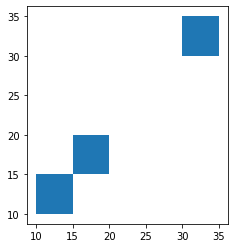

In [23]:
# 一応，可視化して確かめてみる
joined.plot()

## それぞれの商圏に含まれる人口をカウントする (ここが今回のポイント！)
空間結合されたデータ (変数名 joined) を「店舗の名称 (列名 name)」でグルーピングする。

下記のとおり，"shopA" と紐付けられたグループには２つのポリゴンが含まれる。

In [24]:
# (注意) groupby の機能を学生へ説明するためのコード
# ひとつの店舗が複数のポリゴンをカバーすることから，これらをまとめる
for name, group in joined.groupby('name'):
    print(name, group)

shopA    pop                                           geometry  index_right   name
0   30  POLYGON ((10.00000 10.00000, 15.00000 10.00000...            0  shopA
1   50  POLYGON ((15.00000 15.00000, 20.00000 15.00000...            0  shopA
shopB    pop                                           geometry  index_right   name
2  100  POLYGON ((30.00000 30.00000, 35.00000 30.00000...            1  shopB


グループ内の人口(列名 pop)を合計することで，"shopA", "shopB" の商圏に含まれる人口が得られる。

In [25]:
# ひとつの店舗が複数のポリゴンをカバーすることから，これらをまとめる
for name, group in joined.groupby('name'):
    total = group['pop'].sum() # グループ内の合計を得る
    print("{}の商圏人口：{}人".format(name, total))

shopAの商圏人口：80人
shopBの商圏人口：100人
